1. Importing Tools & Libraries

In [42]:
!pip install xgboost

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.model_selection import train_test_split

2. Load Dataset

In [44]:
df = pd.read_csv("HousingData.csv")
df = df.dropna()
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


3. Convert Float Columns to Int

In [45]:
df=df.apply(lambda x : x.astype(int) if x.dtype == 'float64' else x)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0,18,2,0,0,6,65,4,1,296,15,396,4,24
1,0,0,7,0,0,6,78,4,2,242,17,396,9,21
2,0,0,7,0,0,7,61,4,2,242,17,392,4,34
3,0,0,2,0,0,6,45,6,3,222,18,394,2,33
5,0,0,2,0,0,6,58,6,3,222,18,394,5,28


4. Normalize Features 

In [46]:
features=df.columns[df.columns != 'MEDV']
df[features]= (df[features]-df[features].min()) / (df[features].max()-df[features].min())

5. Split Data

In [47]:
x = df.drop('MEDV',axis = 1).values
y = df['MEDV'].values.reshape(-1,1)
n,d = x.shape

6. Train Test Split

In [48]:
idx = int(n* 0.8)
x_train,x_test = x[:idx],x[idx:]
y_train,y_test = y[:idx],y[idx:]

7.  Check and Fix NaNs \ Infs before traning 

In [49]:
x_train = np.nan_to_num(x_train,nan=0.0,posinf=0.0,neginf=0.0)

In [50]:
y_train = np.nan_to_num(y_train,nan=0.0,posinf=0.0,neginf=0.0)

In [51]:
x_test = np.nan_to_num(x_test,nan=0.0,posinf=0.0,neginf=0.0)

In [52]:
y_test = np.nan_to_num(y_test,nan=0.0,posinf=0.0,neginf=0.0)

8. Linear Regression

In [53]:
xb = np.hstack([np.ones((x_train.shape[0],1)),x_train])
theta = np.linalg.pinv(xb) @ y_train
xb_test = np.hstack([np.ones((x_test.shape[0],1)),x_test])
y_pred_lr = xb_test @ theta

9. RMSE & R2

In [54]:
rmse = lambda y, p: np.sqrt(np.mean((y-p)**2))
r2 = lambda y, p: 1-np.sum((y-p)**2) / np.sum((y-y.mean())**2)
print("Linear Regression:")
print("RMSE:" , rmse(y_test,y_pred_lr))
print("R2:" ,r2(y_test,y_pred_lr))

Linear Regression:
RMSE: 4.603027402279148
R2: 0.11432236566198506


10. Random Forest

In [55]:
from random import randint,sample
trees,preds = [],[]
for _ in range(10):
    ixs = [randint(0,len(x_train)-1) for _ in range(len(x_train))]
    feat_idx = sample(range(d),int(np.sqrt(d)))
    x_sub,y_sub = x_train[ixs][:,feat_idx],y_train[ixs]
    low_mask = x_sub[:,0] < x_sub[:,0].mean()
    high_mask = ~low_mask
    avg_low = y_sub[low_mask].mean() if np.any(low_mask) else y_sub.mean()
    avg_high = y_sub[high_mask].mean() if np.any(high_mask) else y_sub.mean()
    pred = np.array([avg_low if x [feat_idx[0]] < x_train[:,feat_idx[0]].mean() else avg_high for x in x_test])
    preds.append(pred.reshape(-1,1))
y_pred_rf = np.mean(preds, axis=0)
print("\n Random Forest:")
print("RMSE:",rmse(y_test,y_pred_rf))
print("R2:",r2(y_test,y_pred_rf))




 Random Forest:
RMSE: 7.442769414324918
R2: -1.3155687808507066


11. XGBoost

In [62]:
residual = y_train.astype(np.float64)
preds =[]
for i in range(10):
    tree = defaultdict(float)
    for i in range(len(residual)):
        b = tuple(x_train[i] > x_train.mean(axis=0))
        tree[b] += residual[1][0]
        for b in tree: tree[b] /= list(b).count(True)
        pred = np.array([tree[tuple(x > x_train.mean(axis=0))] for x in x_train]).reshape(-1,1)
        residual -= 0.1*pred
        preds.append((0.1,tree))
y_pred_xgb = np.zeros((len(x_test),1))
for lr,tree in preds:
    for i, x in enumerate(x_test):
        y_pred_xgb[i] += lr*tree[tuple(x > X_train.mean(axis=0))]

NameError: name 'X_train' is not defined

In [58]:
print("\n XGBoost :")
print("RMSE :",rmse(y_test,y_pred_xgb))
print("R2 :",r2(y_test,y_pred_xgb))


 XGBoost :
RMSE : 15.994065355070877
R2 : -9.693165530267512


12. Feature Importance 

In [ ]:
importances = np.zeros(d)
for _ in range(100):
    f = randint(0,d-1)
    left = y_train[x_train[:,f] < x_train[:,f].mean()]
    right = y_train[x_train[:,f] >= x_train[:,f].mean()]
    total_var = y_train.var()
    if len(left) > 0 and len(left) > 0:
        split_var = (left.var()*len(left)+right.var()*len(right))/len(y_train)
    else:
        split_var = float('inf')
    
    importances[f] += total_var - split_var

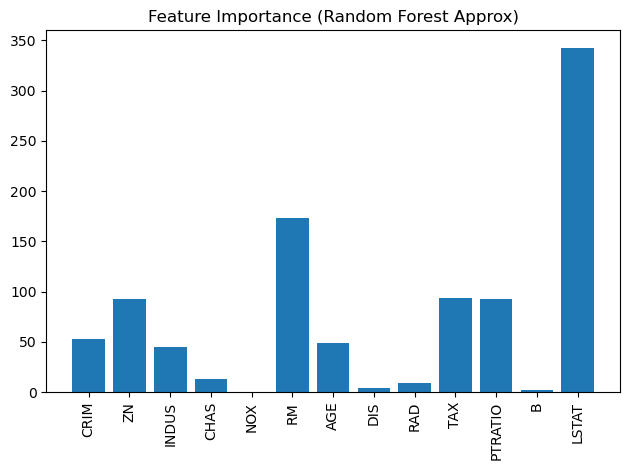

In [63]:
feature_names = df.drop('MEDV',axis=1).columns
plt.bar(feature_names,importances)
plt.xticks(rotation = 90)
plt.title("Feature Importance (Random Forest Approx)")
plt.tight_layout()
plt.show()